# L&S 88 - Final Project - Airplane Etiquette Analysis
_Anna Burns, Howard Yan, Jordan Bailey_

In this notebook, we will attempt to reproduce the result of the analysis by Walt Hickey in his article _41 Percent Of Fliers Think You're Rude If You Recline Your Seat_ The original analysis is hosted [on FiveThirtyEight](https://fivethirtyeight.com/features/airplane-etiquette-recline-seat/). The original analysis computed statistics on survey data in an attempt to determine what the public feels is proper airplane etiquette.


**Table of Contents**
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Reproducing the Statistics](#Reproducing-the-Statistics)
3. [A/B Testing Without Outliers](#A/B-Testing-Without-Outliers)
4. [Reliability of the Data](#Reliability-of-the-Data)
5. [Conclusions](#Conclusions)
6. [Sources](#Sources)

In [2]:
from datascience import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Exploratory Data Analysis

We begin by loading in the dataset which was downloaded from Github.

In [3]:
data = Table.read_table('https://raw.githubusercontent.com/ls88-openscienceconnector/final-project-team-2/master/data/flying-etiquette.csv')
data.show(5)

RespondentID,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,"In a row of three seats, who should get to use the two arm rests?","In a row of two seats, who should get to use the middle arm rest?",Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Is it rude to ask someone to switch seats with you in order to be closer to friends?,Is itrude to ask someone to switch seats with you in order to be closer to family?,Is it rude to wake a passenger up if you are trying to go to the bathroom?,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Age,Household Income,Education,Location (Census Region)
3436139758,Once a year or less,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3434278696,Once a year or less,About half the time,"6'3""",Yes,The arm rests should be shared,The arm rests should be shared,Everyone in the row should have some say,"No, not rude at all","No, not at all rude",Twice,"Yes, they should not recline their chair if the person behind them asks them not to","Yes, somewhat rude",No,"No, not at all rude","No, not at all rude","No, not at all rude","No, not at all rude","No, not at all rude","No, not at all rude",No,No,Male,30-44,nan,Graduate degree,Pacific
3434275578,Once a year or less,Usually,"5'8""",No,Whoever puts their arm on the arm rest first,The arm rests should be shared,The person in the window seat should have exclusive control,"No, not rude at all","No, not at all rude",Three times,"Yes, they should not recline their chair if the person behind them asks them not to","No, not rude at all",No,"No, not at all rude","No, not at all rude","No, not at all rude","Yes, somewhat rude","Yes, somewhat rude","Yes, very rude",No,No,Male,30-44,"$100,000 - $149,999",Bachelor degree,Pacific
3434268208,Once a year or less,Always,"5'11""",No,The arm rests should be shared,The arm rests should be shared,Everyone in the row should have some say,"No, not rude at all","No, not at all rude",Three times,"No, the person on the flight has no obligation to the person behind them","No, not rude at all",No,"Yes, somewhat rude","No, not at all rude","No, not at all rude","Yes, somewhat rude","Yes, somewhat rude","Yes, very rude",No,No,Male,30-44,"$0 - $24,999",Bachelor degree,Pacific
3434250245,Once a month or less,About half the time,"5'7""",No,The person in the middle seat gets both arm rests,The person in aisle,Everyone in the row should have some say,"No, not rude at all","No, not at all rude",Twice,"No, the person on the flight has no obligation to the person behind them","No, not rude at all",No,"No, not at all rude","No, not at all rude","Yes, somewhat rude","Yes, somewhat rude","Yes, somewhat rude","Yes, very rude",Yes,No,Male,30-44,"$50,000 - $99,999",Bachelor degree,Pacific


In the article, Hickey only focuses on people who didn't answer "Never" to the question "How often do you travel by plane?". Here we remove those rows to clean the data.

In [4]:
data= data.where("How often do you travel by plane?", are.not_equal_to("Never"))
data.num_rows

874

The article does not provide a lot of information of the types of responses they recieved. Here we do some exploratory analysis to see the demographics of the people who responded to the survey.

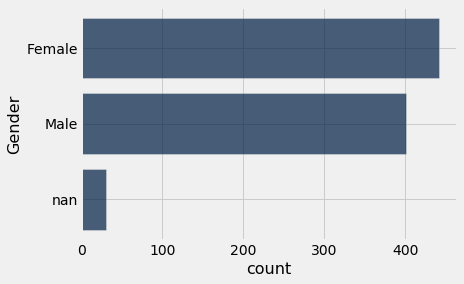

In [5]:
data.group("Gender").barh(0)

**Here, we observe there are more females than males in the dataset.**

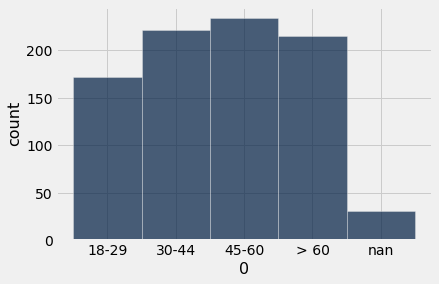

In [6]:
data.group("Age").bar(0)

**The age is centered aroud 44-45.**

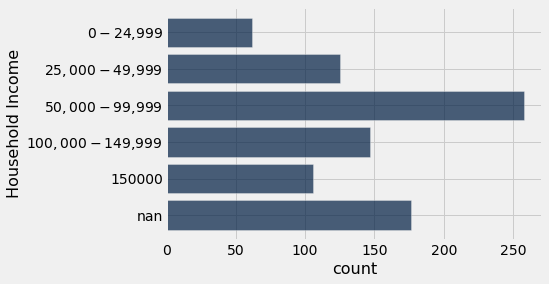

In [7]:
data.group("Household Income").with_column("order", make_array(0, 3, 1,  2, 4, 5)).sort("order").drop("order").barh(0)

**The household income is centered around 50-99,000 per year.**

In [8]:
data.group("Education")

Education,count
Bachelor degree,279
Graduate degree,265
High school degree,61
Less than high school degree,6
Some college or Associate degree,226
nan,37


In [9]:
data.group("Location (Census Region)")

Location (Census Region),count
East North Central,122
East South Central,25
Middle Atlantic,111
Mountain,54
New England,55
Pacific,185
South Atlantic,138
West North Central,66
West South Central,81
nan,37


**What about for those who had never took an airplane ride? Can we find any additional information about this group, since it was included in the data? Let's filter the original data including NaN values.**

In [10]:
data_original = Table.read_table('https://raw.githubusercontent.com/ls88-openscienceconnector/final-project-team-2/master/data/flying-etiquette.csv')
data_original = data_original.where("How often do you travel by plane?", "Never").drop([0,1,22, 23,24,25, 26])
data_original.show(5)

Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,"In a row of three seats, who should get to use the two arm rests?","In a row of two seats, who should get to use the middle arm rest?",Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Is it rude to ask someone to switch seats with you in order to be closer to friends?,Is itrude to ask someone to switch seats with you in order to be closer to family?,Is it rude to wake a passenger up if you are trying to go to the bathroom?,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


**There are lots of NaN values here! Just to be sure, did all people who said "Never", had no responses to any of the questions?**

In [11]:
def allcontainsNan(x):
    for col in x:
        if "nan" not in x.column(col):
            return False
    return True
allcontainsNan(data_original)

True

**Of course! Now, lets see the demographics of those who responded "Never" from the data.**

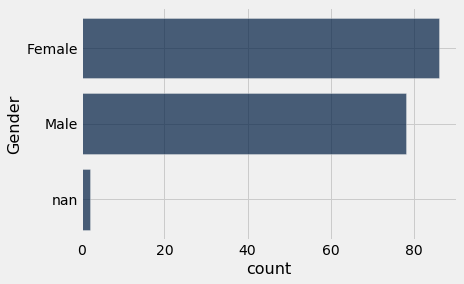

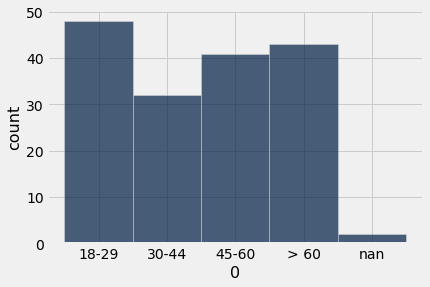

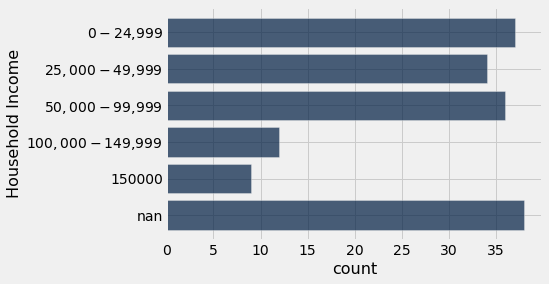

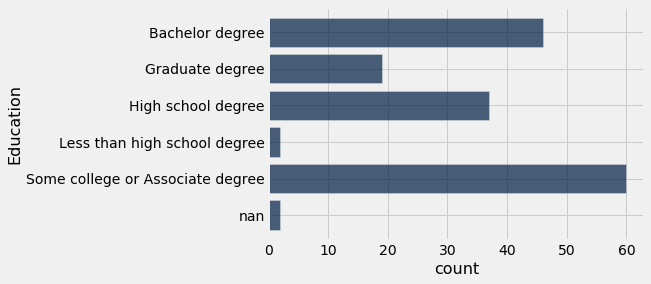

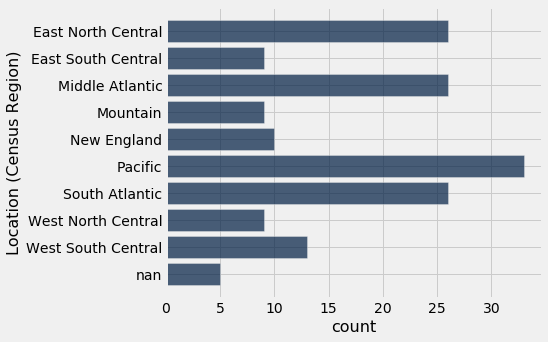

In [12]:
data_original = Table.read_table('https://raw.githubusercontent.com/ls88-openscienceconnector/final-project-team-2/master/data/flying-etiquette.csv')
data_original = data_original.where("How often do you travel by plane?", "Never")

data_original.group("Gender").barh(0)
data_original.group("Age").bar(0)
data_original.group("Household Income").with_column("order", make_array(0, 3, 1,  2, 4, 5)).sort("order").drop("order").barh(0)
data_original.group("Education").barh(0)
data_original.group("Location (Census Region)").barh(0)

**Based on these demographics...**

1. There are slightly more females than men who responded with "Never".
2. Those who are **younger** (millenials) are more likely to never been in an airplane ride.
3. Those who are living in **lower income** are more likely to never been in an airplane ride (affordability factor?).
4. More people who have **some college or an Associates degree** have never been in an airplane ride. (cost factors from tuition fees?)
5. More people who are from the **Pacific** have never been in an airplane ride.


## Is the distrubution those who have never flown an airplane in the survey the same as whole US population? 
Based on a 2016 article entitled, 
[How Much of the World’s Population Has Flown in an Airplane?](https://www.airspacemag.com/daily-planet/how-much-worlds-population-has-flown-airplane-180957719/), the Omnibus Household Survey conducted by the U.S. Bureau of Transportation Statistics that estimated from 2003, 18% of Americans said they had never flown in their life. There is a lot of estimation an guess involved since there isn't concrete data for everyone's experience of flight, but we do have the information from the survey. **Does the survey's sample represent the probability of all Americans who have never flown on an airplane?** Let's create a null and an alternative hypothesis.


**Null hypothesis:** The probability distribution of a person from the data set that has never been in an airplane is equivalent to the distribution of the US. Any difference is due to chance.

**Alternative hypothesis:** The probability is different for both the sample and the US population.

**Let's find out the observed value in the dataset for those who has never flown by finding the proportion of those who haven't been and the total people in the survey.**

In [13]:
observed_never_flown = (data_original.num_rows / data.num_rows)
observed_never_flown

0.18993135011441648

**Now, we will return a simulated test statistic by sampling proportions based on our null hypothesis (18%) and finding the distance between our observed value and the simulated null statistic.**

In [14]:
proportions = make_array(.82, .18)

def test_statistic():
    simulated_stat = sample_proportions(data.num_rows, proportions).item(1)
    return observed_never_flown - simulated_stat
test_statistic()

0.012585812356979392

**Now we will use test statistic to simulate 10,000 times under our null hypothesis of distances between our observed values.**

In [15]:
simulation = make_array()

for i in np.arange(10000): 
    simulated_stat = test_statistic()
    simulation = np.append(simulated_stat, simulation)
    
simulation

array([0.00915332, 0.00114416, 0.02745995, ..., 0.02402746, 0.01144165,
       0.03089245])

**Now let make a histogram of our array of test statistics simulation! Our observed value from the sample is the red dot.**

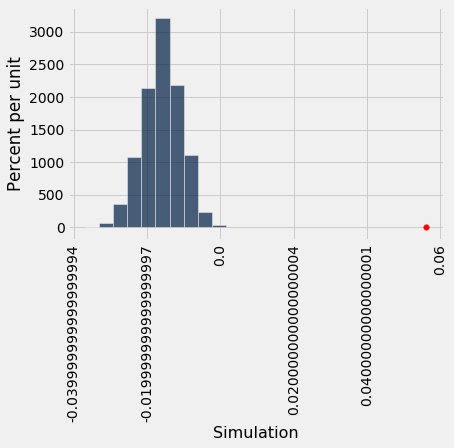

In [16]:
simulation_table = Table().with_column('Simulation', simulation).hist()
plt.scatter(observed_never_flown, 0, color='red', s=30);

**Obviously in this graph, our P-value is 0, therefore this is statistically significant and we can easily reject the null hypothesis. Therefore, our simulation shows that our sample does not represent the distribution of the US population.**

In [17]:
low_per = percentile(2.5, simulation)
high_per = percentile(97.5, simulation)

print("Our 95% confidence interval is [" + str(low_per) + "," + str(high_per) + "]")

Our 95% confidence interval is [-0.01601830663615561,0.03546910755148741]


**Our 95% confidence interval is (-0.01, 0.03). Our observed value (0.18) is higher than the 95% confidence interval, therefore we can say that the sample overestimates the amount of people who has never flown in an airplane.**

## Reproducing the Statistics
In this section, we will go through each claim of the article and recalculate their statistics. The methods are outlined for the first claim, then streamlined into a function to be repeated for the remaining claims.

**The first claim from the article:** "Let’s first tackle the question of reclining seats. Of 858 respondents, 16 percent always recline, 20 percent usually do, 14 percent recline about half the time, 30 percent do only once in a while, and 20 percent never recline."

_The first step is to select the particular question we're interested in and remove the "nan" values (people who didn't answer the question)_

In [18]:
seats_no_na = data.select("Do you ever recline your seat when you fly?").where(0, are.not_equal_to("nan"))
seats_no_na.show(5)

Do you ever recline your seat when you fly?
About half the time
Usually
Always
About half the time
Usually


_Next, we group the responses to get a count for each response, then convert that count into a percentage._

In [19]:
seats_percentages = seats_no_na.group(0)
sum_to_perc = seats_percentages.column("count") / seats_no_na.num_rows
seats_percentages = seats_percentages.with_column("Percentages", sum_to_perc * 100).drop("count")
seats_percentages

Do you ever recline your seat when you fly?,Percentages
About half the time,13.7529
Always,15.9674
Never,19.9301
Once in a while,29.9534
Usually,20.3963


_This plot helps visualize the results we found._

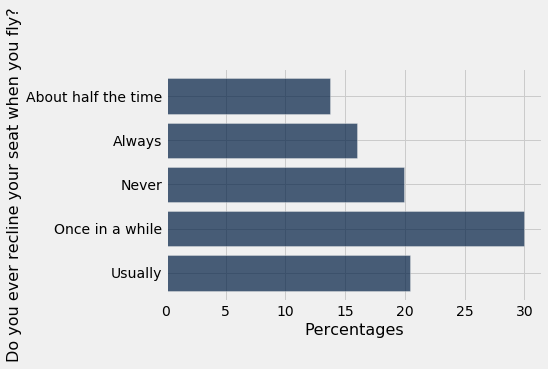

In [20]:
seats_percentages.barh(0)

Here, we define a function to streamline the analysis process. We can simply insert the question label and get back a table of the percentages of respondants' answers.

In [21]:
def percentages_from_label(col_label):
    no_na_data = data.select(col_label).where(0, are.not_equal_to("nan"))
    print(str(np.round(100 * no_na_data.num_rows / data.num_rows, decimals = 2)) + "% (" + str(no_na_data.num_rows) + "/874) of those surveyed answered the question")
    grouped_tbl = no_na_data.group(0)
    count_to_perc = grouped_tbl.column("count") / no_na_data.num_rows
    tbl_w_percentages = grouped_tbl.with_column("Percentages", count_to_perc * 100).drop("count")
    return tbl_w_percentages

**Here, we list the questions to insert into the function.**

In [22]:
data.labels

('RespondentID',
 'How often do you travel by plane?',
 'Do you ever recline your seat when you fly?',
 'How tall are you?',
 'Do you have any children under 18?',
 'In a row of three seats, who should get to use the two arm rests?',
 'In a row of two seats, who should get to use the middle arm rest?',
 'Who should have control over the window shade?',
 'Is itrude to move to an unsold seat on a plane?',
 'Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?',
 "On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?",
 'Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?',
 'Is itrude to recline your seat on a plane?',
 'Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?',
 'Is it rude to ask someone to switch seats with you in order to be closer to f

**Claim from article:** "Only 41 percent of respondents thought it was very or somewhat rude to recline your seat during a flight."

In [23]:
percentages_from_label("Is itrude to recline your seat on a plane?")

97.71% (854/874) of those surveyed answered the question


Is itrude to recline your seat on a plane?,Percentages
"No, not rude at all",58.7822
"Yes, somewhat rude",32.904
"Yes, very rude",8.31382


**Claim from article:** "Most people (70 percent) said they would not eliminate the option to recline seats on flights. "

In [24]:
percentages_from_label("Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?")

97.71% (854/874) of those surveyed answered the question


"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Percentages
No,69.6721
Yes,30.3279


**Claim from article:** "\[...\] most people (64 percent) also said passengers should not recline if the flier behind them asks them not to. The rest of them said a passenger has no obligation to the person behind them."

In [25]:
percentages_from_label('Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?')

97.71% (854/874) of those surveyed answered the question


"Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Percentages
"No, the person on the flight has no obligation to the person behind them",36.4169
"Yes, they should not recline their chair if the person behind them asks them not to",63.5831


**Graph displayed from article:** "We also asked people about common aggravating behaviors on flights to determine whether those actions were very rude, somewhat rude or not rude at all."
![Rudeness Scale Graph](../images/hickey-datalab-flying.png)

**Claim from article:** "Interestingly, people’s responses to questions about kids depended a lot on whether they had children younger than 18. Only 21 percent of 188 parents thought bringing unruly children on a plane was “very rude,” compared to 47 percent of the 657 people without kids. Passengers without children under 18 were three times as likely to consider bringing a baby on a plane very or somewhat rude than people with kids."

In [26]:
percentages_from_label('In general, is it rude to knowingly bring unruly children on a plane?')

97.14% (849/874) of those surveyed answered the question


"In general, is it rude to knowingly bring unruly children on a plane?",Percentages
"No, not at all rude",17.3145
"Yes, somewhat rude",41.3428
"Yes, very rude",41.3428


**Claim from article:** "Only 14 percent of fliers said that, in a row with three seats, the person seated in the middle got both arm rests. Ten percent of respondents are fascists who said whoever puts their arm on the arm rest first gets it; 2 percent are sadists who think the people in the aisle and window seats get both arm rests; and 67 percent are socialists who think they should be shared. Five percent responded “other” and wrote in responses such as “whoever is largest” or “the youngest child” or “me.”"

In [27]:
percentages_from_label('In a row of three seats, who should get to use the two arm rests?')

97.94% (856/874) of those surveyed answered the question


"In a row of three seats, who should get to use the two arm rests?",Percentages
Other (please specify),5.25701
The arm rests should be shared,68.5748
The people in the aisle and window seats get both arm rests,2.1028
The person in the middle seat gets both arm rests,13.9019
Whoever puts their arm on the arm rest first,10.1636


**Claim from article:** "Forty-two percent of respondents acknowledged that the person in the window seat should control the shade, and 58 percent thought everyone should have a say in the shade’s status."

In [28]:
percentages_from_label('Who should have control over the window shade?')

97.94% (856/874) of those surveyed answered the question


Who should have control over the window shade?,Percentages
Everyone in the row should have some say,57.8271
The person in the window seat should have exclusive control,42.1729


**Lets make a deeper analysis about the shade responses that the article didn't talk about.**

**What would be more interesting is by grouping the responses by gender to see if there would be any differences of percentages between men and women compared to both genders.**

**First, we will create 2 tables of the data for each gender.**

In [29]:
data_male = data.where("Gender", "Male")
data_female = data.where("Gender", "Female")

print("Males: " + str(data_male.num_rows), "Females: " + str(data_female.num_rows))

Males: 401 Females: 442


**Then, we will take the responses from each table while also removing any NaN values.**

In [30]:
data_male_q = data_male.select("Who should have control over the window shade?").where(0, are.not_equal_to("nan"))
data_female_q = data_female.select("Who should have control over the window shade?").where(0, are.not_equal_to("nan"))

print("Male Respondents")
data_male_q.show(5)
print("Female Respondents")
data_female_q.show(5)

Male Respondents


Who should have control over the window shade?
Everyone in the row should have some say
The person in the window seat should have exclusive control
Everyone in the row should have some say
Everyone in the row should have some say
The person in the window seat should have exclusive control


Female Respondents


Who should have control over the window shade?
The person in the window seat should have exclusive control
The person in the window seat should have exclusive control
Everyone in the row should have some say
Everyone in the row should have some say
The person in the window seat should have exclusive control


**Now, we group each responses from the male and female tables by "count" to find the percentages, similarly to the percentages_from_label function.**

In [31]:
male_group = data_male_q.group(0)
male_per = male_group.column("count")/data_male.num_rows
male_per_table = male_group.with_column("Percentages", male_per * 100).drop("count")

female_group = data_female_q.group(0)
female_per = female_group.column("count")/data_female.num_rows
female_per_table = female_group.with_column("Percentages", female_per * 100).drop("count")

male_per_table

Who should have control over the window shade?,Percentages
Everyone in the row should have some say,56.6085
The person in the window seat should have exclusive control,43.3915


**There are 56% of males who believed that everyone should have some say, and 43% believe that the person in the window seat should have exclusive control. These percentages are similar when comparing the responses overall.**

In [32]:
female_per_table

Who should have control over the window shade?,Percentages
Everyone in the row should have some say,59.5023
The person in the window seat should have exclusive control,40.4977


**More women responded that everyone in the row should have some say in shade, similarly to the responses overall. However, there is a slightly higher percentage of women who had this response than men.**

**Therefore, in the survey, there was a slightly more women who believed that everyone in the row have their preferable amount of shade.**

**Here is a bar chart, comparing these 2 genders.**

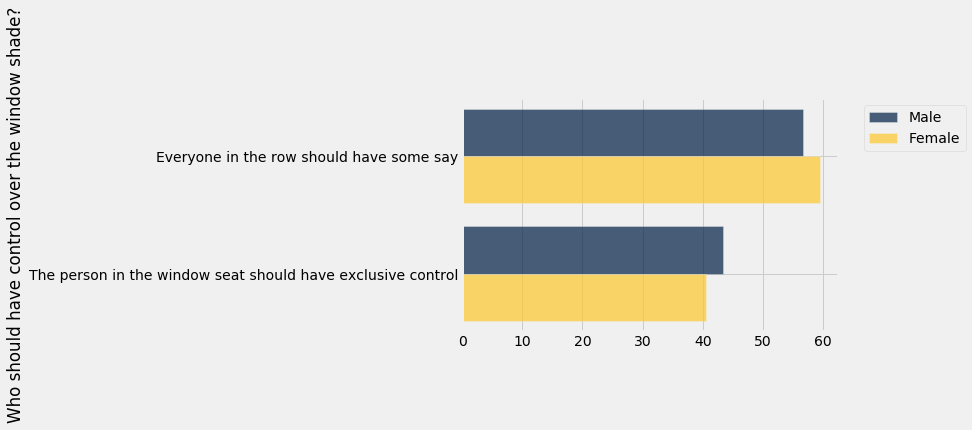

In [33]:
male_and_female = Table().with_columns(
            "Who should have control over the window shade?", male_per_table.column(0),
            "Male", male_per_table.column(1),
            "Female", female_per_table.column(1))
male_and_female.barh("Who should have control over the window shade?")

**Claim from article:** "A full 16 percent of respondents had used personal electronics during take off and landing in violation of the direction of flight attendants."

In [34]:
percentages_from_label("Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?")

97.14% (849/874) of those surveyed answered the question


Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Percentages
No,83.9812
Yes,16.0188


**Claim from article:** "do people actually smoke in bathrooms? — seven respondents admitted they had illegally smoked there."

***I think this one might be a fun one to try bootstrapping***

In [35]:
percentages_from_label('Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?')

97.14% (849/874) of those surveyed answered the question


Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Percentages
No,99.1755
Yes,0.824499


**Here, we run a simulation to determine the true proportion of passangers who have smoked in the bathroom.**

**Write function for histogram.**

In [36]:
def true_smokers(repetitions):
    smokers_collect=make_array()
    for i in np.arange(repetitions):
        shuffle_table=data.sample()
        how_many_smoke=shuffle_table.select('Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?')
        how_many_smoke_2=how_many_smoke.where(0,'Yes')
        proportion_of_smokers=how_many_smoke_2.num_rows/data.num_rows
        smokers_collect=np.append(smokers_collect,proportion_of_smokers)
    return smokers_collect
    
def histogram_smokers(repetitions):
    create_array=true_smokers(repetitions)
    create_table=Table().with_column('Proportion of smokers',create_array)
    return create_table.hist()

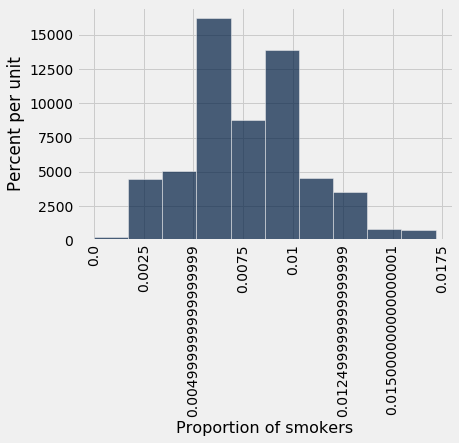

In [37]:
histogram_smokers(2000)

In [38]:
true_smokers(2000)

array([0.01029748, 0.00800915, 0.00457666, ..., 0.00800915, 0.00915332,
       0.00686499])

In [39]:
def confidence_level(confidence_level,repetitions):
    step_1=percentile(confidence_level,true_smokers(repetitions))
    step_2=percentile(100-confidence_level,true_smokers(repetitions))
    return step_2,step_1

In [40]:
confidence_level(95,2000)

(0.003432494279176201, 0.013729977116704805)

**We estimate with 95% confidence that the true proportion of passangers who smoked on the flight is between 0.34% and 1.37%.**

# This is the end of the article's claims.  
I think it might be interesting to try and see if there's a relationship between people's height and how they feel about reclining seats. 

Also bootstrapping the percentage of people who smoke. It would also be interesting to create some visualizations for these. 

I think we should also look more at the na values, it would be good to make a plot of how many nan values there are in each column. 

It would be fun to add some pictures / colors to graphs or something to make it more interesting.

Those are just the things I thought of, I'm sure there's more. All of the cells below are what was here by default, we can use it for inspiration / a template for our analysis, but it can also just be ignored for now. 

Because we are interested in the variables `charges` and `smoking`, we plot box plots below for the insurance charges separated into smoker and non-smoker groups.

In [ ]:
smoker = data.where('smoker', 'yes').column('charges')
nonsmoker = data.where('smoker', 'no').column('charges')
plt.boxplot([smoker, nonsmoker])
plt.title('Boxplots of Smoker and Nonsmoker Charges')
plt.ylabel('Charges ($)')
plt.xlabel('Smoker; 1 = Y, 2 = N')
plt.savefig("../output/smoker-boxplots-datascience.png"); # export to output folder

## Reproducing the A/B

In this section of the notebook, we will attempt to reproduce the original A/B test that was run on the data. The test statistic that was used was the absolute difference between the mean charges for the smoker and non-smoker groups. That is, for two vectors of $n$ smoker charges $\mathbf{s}$ and $m$ non-smoker charges $\mathbf{\bar{s}}$, the test statistic is computed as

$$ \left | \frac{1}{n} \sum_{i=1}^n s_i - \frac{1}{m} \sum_{i=1}^m \bar{s}_i \right | $$

To accomplish this, we first define a function `test_statistic` that takes in a table with columns `smoker` and `charges` and computes the value of the test statistic.

In [ ]:
def test_statistic(tbl):
    grouped = (tbl
               .group('smoker', np.mean)             # group by smoker values and take mean of cols
               .select('smoker', 'charges mean'))    # select smoker and charges mean cols
    smoker = (grouped
              .where('smoker', 'yes')                # select the row where smoker is 'yes'
              .column('charges mean'))[0]            # take that value of charges mean col
    nonsmoker = (grouped
                 .where('smoker', 'no')              # select the row where smoker is 'yes'
                 .column('charges mean'))[0]         # take that value of charges mean col
    
    return abs(smoker - nonsmoker)                   # return absolute difference

test_statistic(data)    # running the function on the original data

We now turn our attention to the A/B test. The purpose of the A/B test is to determine whether or not the charges for smokers and non-smokers come from the same underlying distribution. For this A/B test the null and alternative hypotheses are as follows:

* $H_0$: There is not difference between the distributions of charges for smokers and non-smokers. Any difference observed is due to random chance.
* $H_A$: Being a smoker affects what you are charged in insurance premia; that is, the smoker and non-smoker charges are not from the same distribution.

To check the intuition of $H_A$, we first plot histograms of the data on the same axes to see if the distributions match visually.

In [ ]:
plt.hist(smoker, density=True, alpha=0.5)       # reusing the smoker array created earlier
plt.hist(nonsmoker, density=True, alpha=0.5)    # reusing the nonsmoker array created earlier
plt.title('Histograms of Smoker and Non-Smoker Charges')
plt.xlabel('Charges ($)')
plt.legend(['Smoker', 'Non-Smoker'])
plt.savefig("../output/charges-hist-dstascience.png"); # export to output folder

Based on the above visualization, it appears our intuition is correct, but we should nevertheless verify this statistically. The A/B test will occur in steps that will culminate in calculating a p-value to determine whether we accept $H_0$ or $H_A$. The steps we will follow are enumerated below:
1. Define a function `shuffle` to shuffle the table's smoker classifications
2. Repeatedly shuffle the table and apply the function `test_statistic`
3. Calculate the proportion of values of the test statistic that are **greater than or equal to** the value for the original table

To begin, we define the function `shuffle` below which shuffles the table.

In [ ]:
def shuffle(tbl):
    new_tbl = tbl.copy()    # copy the table so we don't mutate the original
    smoker_status = (new_tbl
                     .sample(with_replacement=False)    # shuffle the table by sampling without replacement
                     .column('smoker'))                 # select smoker column from shuffle table
    new_tbl['smoker'] = smoker_status
    return new_tbl

shuffle(data).show(5)    # test the function on the original data table

For the second step of the process, we use a for loop below to run through the repetitions. A list is used instead of an array below to make the code run faster.

In [ ]:
np.random.seed(13)       # seeding np.random to make results reproducible
reps = 10000             # number of repetitions to run through
test_statistics = []     # initialize array to collect values
for _ in np.arange(reps):
    shuffled_data = shuffle(data)                 # shuffle data table
    test_stat = test_statistic(shuffled_data)     # calculate test statistic on shuffled table
    test_statistics += [test_stat]                # add value to test_statistics list

Finally, we calculate the p-value below.

In [ ]:
# calculate value of test statistic for original data
original = test_statistic(data)

# calculate p-value
p_value = sum(test_statistics >= original) / len(test_statistics)     

print("The p-value for this A/B test is {}.".format(p_value))

The p-value is apparently 0, which is significant by any convention. So, in this case, we accept $H_A$, that the smoker and non-smoker charges do not come from the same underlying distribution.

## A/B Testing Without Outliers

The original analysis fails to consider the effect of outliers on the results that it derives. In order to see if this has an effect, we now run the same test on a data set where we have taken out the outliers _within each smoking group_. That is, we first separate the individuals into smokers and non-smokers, and then remove outliers from each subset.

For the purposes of this analysis, we define outliers to be values that are more than 2.5 standard deviations ($\sigma$) away from the mean ($\mu$). That is, the set of outliers $O$ is

$$O = \{ c_i \mid c_i < \mu - 2.5 \sigma \} \cup \{ c_i \mid c_i > \mu + 2.5 \sigma \}$$

In the cell below, we remove these data from the data table.

In [ ]:
all_smokers = data.where('smoker', 'yes')
mu_smokers, sigma_smokers = np.mean(all_smokers['charges']), np.std(all_smokers['charges'])
smokers = all_smokers.where('charges', are.between_or_equal_to(
    mu_smokers - 2.5 * sigma_smokers,
    mu_smokers + 2.5 * sigma_smokers
))

print('Number of removed smokers: {}'.format(all_smokers.num_rows - smokers.num_rows))

In [ ]:
all_non_smokers = data.where('smoker', 'no')
mu_non_smokers, sigma_non_smokers = np.mean(all_non_smokers['charges']), np.std(all_non_smokers['charges'])
non_smokers = all_non_smokers.where('charges', are.between_or_equal_to(
    mu_non_smokers - 2.5 * sigma_non_smokers,
    mu_non_smokers + 2.5 * sigma_non_smokers
))

print('Number of removed non-smokers: {}'.format(all_non_smokers.num_rows - non_smokers.num_rows))

Because we removed outliers in the data set, we now recreate the data table without outliers from the `smokers` and `non_smokers` dataframes and run the A/B test.

In [ ]:
no_outliers = smokers.with_rows(non_smokers.rows)
print(no_outliers.num_rows == data.num_rows - 43)

In [ ]:
np.random.seed(13)       # seeding np.random to make results reproducible
reps = 10000             # number of repetitions to run through
no_outliers_test_statistics = []     # initialize array to collect values
for _ in np.arange(reps):
    shuffled_data = shuffle(no_outliers)          # shuffle data table
    test_stat = test_statistic(shuffled_data)     # calculate test statistic on shuffled table
    no_outliers_test_statistics += [test_stat]    # add value to test_statistics list

Finally, we calculate the p-value below.

In [ ]:
# calculate value of test statistic for original data
no_outliers_original = test_statistic(no_outliers)

# calculate p-value
no_outliers_p_value = sum(no_outliers_test_statistics >= no_outliers_original) \
        / len(no_outliers_test_statistics)     

print("The p-value for this A/B test is {}.".format(no_outliers_p_value))

Because the result of this A/B test is also 0, removing outliers had no effect on the outcome of the hypothesis test, and so we still accept $H_A$. This shows that removing outliers does not effect the findings of the original analysis.

## Reliability of the Data

The original data on which this analysis is based was downloaded from Kaggle. Given that Kaggle is a community where anyone can post data regardless of its quality, in this section we attempt to ascertain whether or not the insurance dataset _is_ of good quality by considering its origin and structure.

The following is an excerpt from the "Context" section of the dataset's listing on Kaggle:
> Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book.

The validity of the data has even been called into question in the comment section with people asking about where the data came from, as the Github repo where it is hosted does not contain much information beyond that quoted above.

![Kaggle comment](../images/comment.png)

The Kaggle poster responded by saying that they found the dataset on Github and don't know anything about its provenance beyond that:

![Kaggle response](../images/response.png)

The source for the data is listed in the "Acknowledgements" section, but points to a [Github repository](https://github.com/stedy/Machine-Learning-with-R-datasets) which contains quite a few datasets but no information on their provenance beyond the description listed above, which appears to have been copied from the README of the Github repo. According to these, you need to have a Packt account in order to get access to the data and dependencies. Below is a screengrab from an [online PDF of the textbook](https://edu.kpfu.ru/pluginfile.php/278552/mod_resource/content/1/MachineLearningR__Brett_Lantz.pdf) that describes the `insurance.csv` file that this dataset is from:

![textbook screengrab](../images/textbook.png)

A cursory examination of the book yielded no other information about the data's provenance. Because the textbook refers to the data as "simulated" and there is no other reference to data gathering in the book, we cannot say that this data is derived from an real-world observation. It is for this reason that we conclude that the data are unreliable, because we do not know the method by which they were simulated or, if they are in fact observations, how the sampling was conducted. This means that we cannot substantiate the statistical significance of any result derived herein, because the data upon which they are founded is inherently flawed.

## Conclusions

In the beginning of this notebook, we looked at the distributions of smoker and non-smoker charges for this dataset and saw visually that they do not appear to be from the same distribution; this was confirmed by running an A/B test on the smoker and non-smoker charges, which yielded a p-value of 0. It is because of the low p-value that we concluded in the direction of $H_A$, that the charges are _not_ from the same underlying distribution.

After reproducing the original A/B test, we attempted to look at whether or not removing outliers from the smoker and non-smoker subsets would provide different, more accurate results, and found 43 outliers to remove (2 in the smoking group, 41 in the non-smoking group). After running the A/B test on the data without outliers, we concluded due to the p-value of 0 that removing outliers had no effect on the outcome (and, therefore, that $H_A$ is the hypothesis supported by the data).

Finally, we considered the provenance of the dataset and traced it back to a book, _Machine Learning with R_ by Brett Lantz, and discovered that the documentation for the dataset did not describe how it was obtained, and in fact described it as "simulated." It was for this reason that we determined that without an assurance of the validity of the data, we could not accept any of the results we produced with it as statistically significant.

Considering the original analysis, it appears that the statistics and coding were sound. We were able to reproduce the result with the same data using some different methods, and used EDA to show visually that the conclusions made sense. In that respect, the original analysis is sound. However, because the original analysis fails to consider the provenance of its data, it makes generalizations that it cannot substantiate given the murky origin of the data upon which it is founding its claims.

## Sources

Hickey, Walt. _41 Percent Of Fliers Think You’re Rude If You Recline Your Seat_. FiveThirtyEight, 2014. [https://fivethirtyeight.com/features/airplane-etiquette-recline-seat/](https://fivethirtyeight.com/features/airplane-etiquette-recline-seat/).

Pyles, Chris. Insurance Data. Github. 12 March 2019. [https://github.com/chrispyles/jupyter/blob/master/content/notebooks/insurance/insurance.ipynb](https://github.com/chrispyles/jupyter/blob/master/content/notebooks/insurance/insurance.ipynb).